Pedro Vitor Almeida de Melo - pvam@cesar.school

Link para o dataset = https://www.kaggle.com/datasets/paramaggarwal/fashion-product-images-small/data

Link para o Drive com o dataset e as imagens - https://drive.google.com/drive/folders/1-HaEnR8iORCdeF--7Ilti8waW8u5RZru?usp=drive_link

# Importando Bibliotecas

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from PIL import Image
import torch
from torch.autograd import Variable
import torch.nn as nn
import torchvision
from torchvision import transforms
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder


# Carregamento do Dataset

In [2]:
# df foi reduzido para 2mil linhas para poder carregar as respectivas imagens no google drive
df = pd.read_csv('/content/drive/MyDrive/RNA e Deep Learning/TF-Dataset/styles.csv', nrows=2000)

In [3]:
df.head()

,id,gender,masterCategory,subCategory,articleType,baseColour,season,year,usage,productDisplayName
0,15970,Men,Apparel,Topwear,Shirts,Navy Blue,Fall,2011,Casual,Turtle Check Men Navy Blue Shirt
1,39386,Men,Apparel,Bottomwear,Jeans,Blue,Summer,2012,Casual,Peter England Men Party Blue Jeans
2,59263,Women,Accessories,Watches,Watches,Silver,Winter,2016,Casual,Titan Women Silver Watch
3,21379,Men,Apparel,Bottomwear,Track Pants,Black,Fall,2011,Casual,Manchester United Men Solid Black Track Pants
4,53759,Men,Apparel,Topwear,Tshirts,Grey,Summer,2012,Casual,Puma Men Grey T-shirt


In [4]:
df.drop(columns=['season', 'usage', 'baseColour', 'year', 'masterCategory', 'articleType', 'productDisplayName', 'gender'], inplace=True)

In [5]:
# Devido a baixa frequencia irei excluir as labels que aparecem menos que cinco vezes

df = df[df['subCategory'].isin(df['subCategory'].value_counts()[df['subCategory'].value_counts() >=5].index)]
df.reset_index(drop=True, inplace=True)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1992 entries, 0 to 1991
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   id           1992 non-null   int64 
 1   subCategory  1992 non-null   object
dtypes: int64(1), object(1)
memory usage: 31.2+ KB


In [7]:
df.head()

,id,subCategory
0,15970,Topwear
1,39386,Bottomwear
2,59263,Watches
3,21379,Bottomwear
4,53759,Topwear


In [8]:
path_list = []
for ids in df.id:
  path_list.append('/content/drive/MyDrive/RNA e Deep Learning/TF-Dataset/images/'+str(ids)+'.jpg')

In [9]:
df['path'] = path_list

In [10]:
df.head()

,id,subCategory,path
0,15970,Topwear,/content/drive/MyDrive/RNA e Deep Learning/TF-...
1,39386,Bottomwear,/content/drive/MyDrive/RNA e Deep Learning/TF-...
2,59263,Watches,/content/drive/MyDrive/RNA e Deep Learning/TF-...
3,21379,Bottomwear,/content/drive/MyDrive/RNA e Deep Learning/TF-...
4,53759,Topwear,/content/drive/MyDrive/RNA e Deep Learning/TF-...


# Definição do Modelo

In [11]:
class Modelo(nn.Module):
    def __init__(self):
        super(Modelo, self).__init__()
        self.dense = nn.Sequential(
            nn.Linear(3*32*32, 64),
            nn.Sigmoid(),
            nn.Linear(64, 64),
            nn.Sigmoid(),
            nn.Linear(64, 28)
        )

    def forward(self, x):
        x = self.dense(x)

        return x

model = Modelo()
print(model)

Modelo(
  (dense): Sequential(
    (0): Linear(in_features=3072, out_features=64, bias=True)
    (1): Sigmoid()
    (2): Linear(in_features=64, out_features=64, bias=True)
    (3): Sigmoid()
    (4): Linear(in_features=64, out_features=28, bias=True)
  )
)


# Treinamento

In [12]:
train_paths, test_paths, train_labels, test_labels = train_test_split(
    df['path'],
    df['subCategory'],
    test_size=0.3,
    stratify=df['subCategory'],
    random_state=42
)

In [13]:
def compress_image(image_path, target_size=(32, 32)):
    # Open the image
    image = Image.open(image_path)

    if image.mode != 'RGB':
        image = image.convert('RGB')
    # Resize image (optional: reduce the size for compression)
    image = image.resize(target_size, Image.Resampling.LANCZOS)

    # Optionally, save a compressed version (for JPEG compression)
    #image.save("compressed_image.jpg", quality=30)  # You can adjust the quality here

    return image

In [14]:
def image_to_tensor(image):
    # Define a transform to convert the PIL image to a PyTorch tensor
    transform = transforms.ToTensor()

    # Convert image to tensor
    tensor = transform(image)

    return tensor

In [15]:
image_tensors = []
for image_path in train_paths:
  image = compress_image(image_path)

  tensor = image_to_tensor(image)

  image_tensors.append(tensor)

all_images_tensor = torch.stack(image_tensors)

torch.save(all_images_tensor, 'train.pt')

In [16]:
image_tensors = []
for image_path in test_paths:
  image = compress_image(image_path)

  tensor = image_to_tensor(image)

  image_tensors.append(tensor)

all_images_tensor = torch.stack(image_tensors)

torch.save(all_images_tensor, 'test.pt')

In [17]:
le = LabelEncoder()
labels = le.fit_transform(train_labels.values)

In [18]:
len(train_labels.unique())

28

In [19]:
x_train = torch.load('/content/train.pt')
y_train = torch.LongTensor(labels)

<ipython-input-19-2f2a22503f3f>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  x_train = torch.load('/content/train.pt')


In [20]:
x_train = x_train.float()

In [21]:
x_train.size()

torch.Size([1394, 3, 32, 32])

(-0.5, 264.5, 99.5, -0.5)

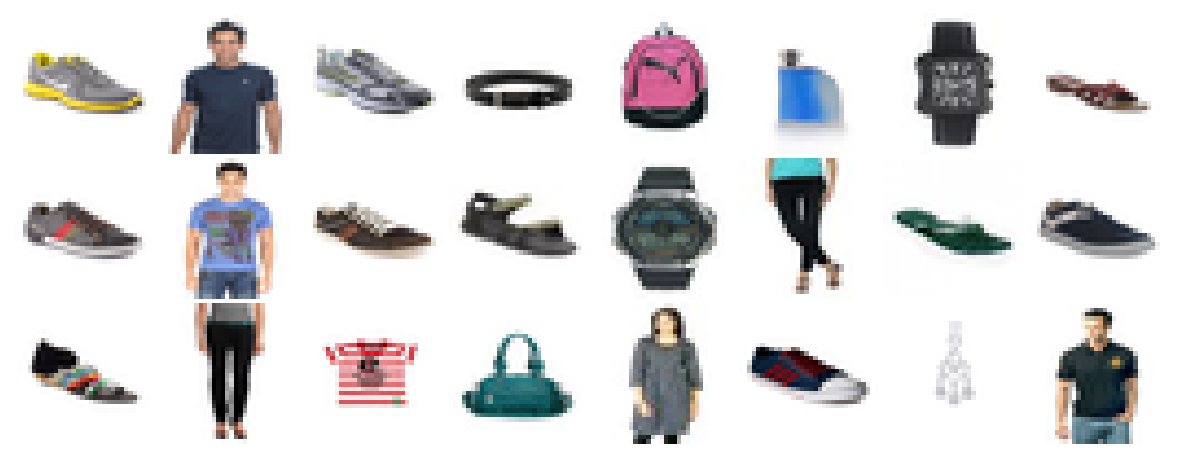

In [22]:
n_samples = 24

# cria um grid com as imagens
grid = torchvision.utils.make_grid(x_train[:n_samples], pad_value=1.0, padding=1)

plt.figure(figsize=(15, 10))
plt.imshow(grid.numpy().transpose(1, 2, 0))
plt.axis('off')

In [23]:
lr = 0.2

optimizer = torch.optim.SGD(model.parameters(), lr=lr)

criterion = nn.CrossEntropyLoss()

In [24]:
nb_epoch = 1500
batch_size = 150  # Número de amostras por batch

losses = []

for epoch in range(nb_epoch):
    # Embaralha os índices para evitar que os batches sejam sempre os mesmos
    permutation = torch.randperm(x_train.size(0))

    for i in range(0, x_train.size(0), batch_size):
        # Selecionando os índices do batch atual
        indices = permutation[i:i+batch_size]
        batch_x = x_train[indices]
        batch_y = y_train[indices]

        inputs = Variable(batch_x.view(batch_x.size(0), -1)) # Keep batch size and flatten the rest
        targets = Variable(batch_y)

        # Forward pass
        output = model(inputs)
        loss = criterion(output, targets)

        # Zero, backpropagation e atualização
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    losses.append(loss.data)

    # Opção para monitorar o progresso
    # if epoch % 20 == 0:
    #   print(f"Epoch {epoch}/{nb_epoch}, Loss: {loss.data}")

print('Final loss:', loss.data)

Final loss: tensor(0.2117)


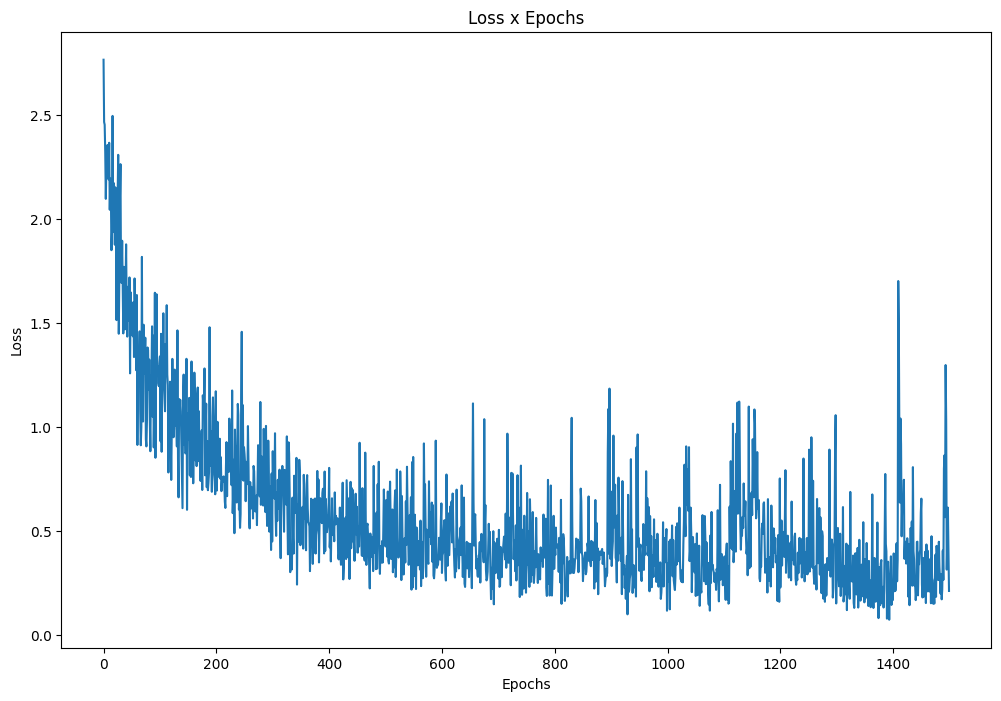

In [25]:
plt.figure(figsize=(12, 8))
plt.plot(losses)
plt.title('Loss x Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()


In [26]:
def predict(model, input_data):
    # Reshape the input data to match the expected shape during training
    input_data = input_data.view(input_data.size(0), -1) # Similar to training preprocessing

    # Wrap input_data with Variable (optional but included for consistency)
    inputs = Variable(input_data)

    outputs = model(inputs)
    _, predicts = torch.max(outputs, 1)
    return predicts # Return the predicted classes

In [27]:
y_pred = predict(model, x_train) # Pass the original x_train without reshaping
accuracy = (y_pred.numpy() == y_train.numpy()).mean()
print('Accuracy:', accuracy)

Accuracy: 0.9067431850789096


In [28]:
pd.set_option('display.max_columns', None)
print('Matriz de confusão:')
print(pd.crosstab(le.inverse_transform(y_pred), le.inverse_transform(y_train)).shape)
pd.crosstab(le.inverse_transform(y_pred), le.inverse_transform(y_train))

Matriz de confusão:
(22, 28)


col_0,Accessories,Apparel Set,Bags,Belts,Bottomwear,Dress,Eyewear,Flip Flops,Fragrance,Free Gifts,Headwear,Innerwear,Jewellery,Lips,Loungewear and Nightwear,Makeup,Mufflers,Nails,Sandal,Saree,Scarves,Shoes,Skin Care,Socks,Ties,Topwear,Wallets,Watches
row_0,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Apparel Set,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
Bags,4,0,104,0,1,2,0,0,3,0,0,0,0,0,0,2,0,0,0,0,1,0,1,1,0,0,3,0
Belts,0,0,1,29,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Bottomwear,0,0,0,0,81,0,0,1,1,1,4,0,2,0,2,1,4,1,0,0,3,0,0,1,0,1,0,0
Dress,0,0,0,0,0,7,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
Eyewear,0,0,0,0,0,0,26,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Flip Flops,0,0,0,0,0,0,0,29,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0
Fragrance,0,0,0,0,0,0,0,0,24,0,0,0,1,2,0,5,0,0,0,0,0,0,1,0,0,0,0,0
Headwear,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [29]:
# Acurácia com dados de teste
labels = le.fit_transform(test_labels.values)

x_test = torch.load('/content/test.pt')
y_test = torch.LongTensor(labels)

<ipython-input-29-389a1e96639e>:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  x_test = torch.load('/content/test.pt')


(-0.5, 264.5, 99.5, -0.5)

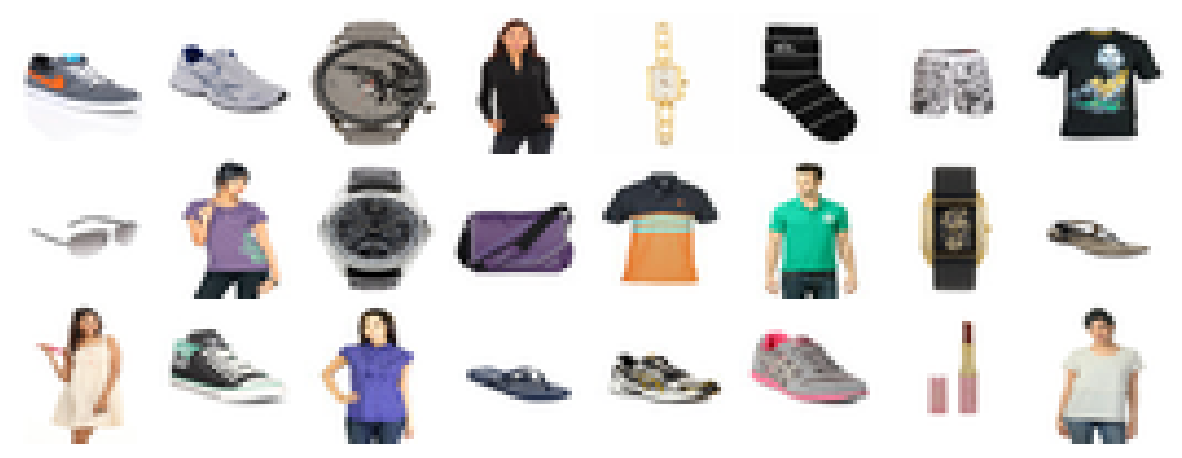

In [30]:
n_samples = 24

# cria um grid com as imagens
grid = torchvision.utils.make_grid(x_test[:n_samples], pad_value=1.0, padding=1)

plt.figure(figsize=(15, 10))
plt.imshow(grid.numpy().transpose(1, 2, 0))
plt.axis('off')

In [31]:
y_pred = predict(model, x_test)
accuracy = (y_pred.numpy() == y_test.numpy()).mean()
print('Accuracy:', accuracy)

Accuracy: 0.8010033444816054


In [32]:
print('Matriz de confusão:')
pd.crosstab(le.inverse_transform(y_pred), le.inverse_transform(y_test))

Matriz de confusão:


col_0,Accessories,Apparel Set,Bags,Belts,Bottomwear,Dress,Eyewear,Flip Flops,Fragrance,Free Gifts,Headwear,Innerwear,Jewellery,Lips,Loungewear and Nightwear,Makeup,Mufflers,Nails,Sandal,Saree,Scarves,Shoes,Skin Care,Socks,Ties,Topwear,Wallets,Watches
row_0,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Apparel Set,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
Bags,1,0,38,0,0,1,0,0,0,0,0,2,0,0,0,1,0,0,0,0,1,0,0,0,0,0,2,0
Belts,0,0,0,12,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
Bottomwear,0,1,1,0,33,0,0,0,2,0,4,2,1,0,0,0,1,0,1,1,1,0,0,0,0,1,1,3
Dress,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,2,0,0
Eyewear,0,0,0,0,0,0,11,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Flip Flops,0,0,0,0,0,0,0,6,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Fragrance,1,0,0,0,0,1,0,0,8,0,0,0,0,4,0,2,0,2,0,0,0,0,1,0,0,0,0,0
Headwear,0,0,0,0,2,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


# Considerações

A implementação de rede neural nesse dataset foi bastante desafiador:
- Primeiramente tomei a decisão de reduzir o dataset para 2 mil elementos, pois a quantidade massiva de dados tornou dificultoso ter que fazer o upload de mais de 40 mil imagens na nuvem para trabalhar no colab;
- Em seguida para comprimir as imagens, a idéia era comprimir em 256 bits para 256, mas os arquivos iriam ficar muito pesados e a quantidade de neuronimos para camada de entrada ia ficar muito grande também, então decidi por 32 bits Essa idéia da compressão era comprimir todas as imagens em um arquivo .pt, como visto no notebook 3.2.
- Para dividir os dados de treino e teste optei por  dividir em 70% para treino e 30% para teste, usando stratify para divir proporcionalmente as labels das imagens entre treino e teste para que os dados não ficasse defasados de algum tipo determinado de label;
- Em seguida, após a compressão das imagens foi feitoa leitura dos dados de treino e suas respectivas labels. O modelo escolhido foi uma rede neural com 3 camadas, com 3*32*32 (RGB* 32px * 32px) neurônios na camada de entrada, e 28 na camada de saída(um para cada classe). A função de ativação inicialmente seria ReLU, mas eu não consegui resultados satisfatórios, até alterar para Sigmoid onde obtive resultados muito melhores. Treinando com um learning rate de 0.2 e um 1500 epochs foi onde encontrei melhores resultados;
- No fim, os resultados foram satisfatórios, com acurácioa de 0.86 para os dados de acerto e de 0.75 para os dados de teste.